# aSPEM Experiment : analysis




TODO: tester qu'à chaque pause, l'agent se réinitialise à $\hat{p}=.5$

In [1]:
%run ../0_parameters.ipynb


WELCOME



In [2]:
import glob
import bayesianchangepoint as bcp

In [3]:
liste = []
for fname in glob.glob('data/*pkl'):
    a = fname.split('/')[1].split('.')[0].split('_')
    liste.append(a)

In [4]:
from aSPEM import Analysis
e = Analysis(name_file_fit='fct_velocity_sigmo')

# find_h_with_MI

/home/drone/.local/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/home/drone/.local/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


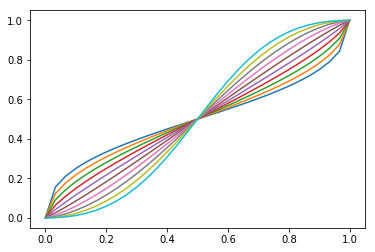

In [5]:
p = np.linspace(0, 1, 31)
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def logit(p):
    return np.log(p / (1 - p))
    
#plt.plot(p, sigmoid(4.*logit(p)))
for x in np.logspace(-1, 1, 10, base=2):
    plt.plot(p, sigmoid(x*logit(p)))

In [6]:
def r_(p, data) :
    
    p = np.ma.masked_array(p, mask=np.isnan(data)).compressed()
    data = np.ma.masked_array(data, mask=np.isnan(data)).compressed()

    from scipy import stats
    slope, intercept, r_, p_value, std_err = stats.linregress(p, data)
    
    return r_

In [7]:
def regress(ax, p, data, t_label=10, color='k', lw=2, axis=None) :
    from scipy import stats
    slope, intercept, r_, p_value, std_err = stats.linregress(p, data)
    x_test = np.linspace(np.min(p), np.max(p), 100)
    fitLine = slope * x_test + intercept
    
    ax.plot(x_test, fitLine, c=color, linewidth=lw)

    if axis is None :
        x1, x2 = np.min(p), np.max(p)
        y1, y2 = np.min(data), np.max(data)
    else :
        x1, x2, y1, y2  = axis[0], axis[1], axis[2], axis[3]
    #x_pos=x2-(x2-x1)/10 ; h_pos='right'
    #x_pos=x1+(x2-x1)/10 ; h_pos='left'
    #y_pos_r=y2-(y2-y1)/10 ; y_pos_m=y2-2*(y2-y1)/10
    y_pos_r=y1+(y2-y1)/10 ; y_pos_m=y1+2*(y2-y1)/10

    
    ax.text(x2, y_pos_r, 'r = %0.3f'%(r_), color=color, fontsize=t_label/1.2, ha='right')
    
    return ax


In [8]:
# https://en.wikipedia.org/wiki/Pearson_correlation_coefficient#Weighted_correlation_coefficient
# https://stackoverflow.com/questions/38641691/weighted-correlation-coefficient-with-pandas
def r_weight(ax, x, y, w, t_label=10, color='k', lw=2, axis=None) :
    
    x = np.ma.masked_array(x, mask=np.isnan(y)).compressed()
    y = np.ma.masked_array(y, mask=np.isnan(y)).compressed()
    
    def m(x, w):
        """Weighted Mean"""
        return np.sum(x * w) / np.sum(w)

    def cov(x, y, w):
        """Weighted Covariance"""
        return np.sum(w * (x - m(x, w)) * (y - m(y, w))) / np.sum(w)

    def corr(x, y, w):
        """Weighted Correlation"""
        return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))    

    r = corr(x, y, w)
    
    
    if axis is None :
        x1, x2 = np.min(x), np.max(x)
        y1, y2 = np.min(y), np.max(y)
    else :
        x1, x2, y1, y2  = axis[0], axis[1], axis[2], axis[3]
    
    
    
    #x_pos=x2-(x2-x1)/10 ; h_pos='right'
    #x_pos=x1+(x2-x1)/10 ; h_pos='left'
    #y_pos_r=y2-(y2-y1)/10 ; y_pos_m=y2-2*(y2-y1)/10
    y_pos_r=y1+(y2-y1)/10 ; y_pos_m=y1+2*(y2-y1)/10

    ax.text(x1, y_pos_r, 'r weight = %0.3f'%(r), color=color, fontsize=t_label/1.2, ha='left')
    
    return ax


In [9]:
Full = e.Full_list(modes_bcp=[])
modes_bcp = 'mean'
tau = np.arange(2, 401, 1)
list_h = 1/tau
#print(h)

for num, s in enumerate(['AM']):#set(Full.sujet)[0]) :
    print(s)#, end=' ')
    
    bet = Full['results'][Full.sujet==s].values.tolist()
    x = np.array(Full['bino'][Full.sujet==s].values.tolist())

    

    r_lala, h_lala = {}, {}
    
    for num, lala in enumerate(np.logspace(-1, 1, 10, base=2)) :
        
        r_bet_logit, r_bet_ = [], []
        for c in range(0, 3*200-50, 50) : r_bet_logit.append([]) ; r_bet_.append([])
        
        for h in list_h :

            for d, c in enumerate(range(0, 3*200-50, 50)) :
                x_100 = x[c:c+100]
                p_hat_100 = np.zeros(100)

                liste = [0, 50, 100]
                for a in range(len(liste)-1) :
                    p_bar, r_bar, beliefs = bcp.inference(x_100[liste[a]:liste[a+1]], h=h, p0=.5, r0=1.)
                    p_hat_p, r_hat = bcp.readout(p_bar, r_bar, beliefs, mode=modes_bcp, p0=.5, fixed_window_size=40)
                    p_hat_100[liste[a]:liste[a+1]] = p_hat_p

                if num==0 : r_bet_[d].append(r_(p_hat_100.tolist(), bet[c:c+100]))
                r_bet_logit[d].append(r_(lala*logit(p_hat_100), bet[c:c+100]))

        h_bet_logit, h_bet_ = [], []
        r_bet_l, r_bet = [], []
        for d, c in enumerate(range(0, 3*200-50, 50)) :

            if num==0 : h_bet_.append(list_h[np.argmax(r_bet_[d])] if np.max(r_bet_[d]) > 0.6 else np.nan)
            h_bet_logit.append(list_h[np.argmax(r_bet_logit[d])] if np.max(r_bet_logit[d]) > 0.6 else np.nan)

            if num==0 : r_bet.append(np.max(r_bet_[d]))
            r_bet_l.append(np.max(r_bet_logit[d]))
            

        if num==0 : print('\nBet :\nh=', h_bet_, '\nr=', r_bet, end='\n\n\n')
        print('\nBet Logit :', num, '-', lala, '\nh=', h_bet_logit, '\nr=', r_bet_l, end='\n\n\n')
        
        if num==0 : h_lala[0]=h_bet_; r_lala[0]=r_bet
        h_lala[num+1]=h_bet_logit ; r_lala[num+1]=r_bet_l

AM

Bet :
h= [0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.003003003003003003, 0.0025, nan, 0.0136986301369863] 
r= [0.8416687489564844, 0.7612808661065305, 0.8713984673172969, 0.8791537886371801, 0.9305390401954183, 0.9493051736904605, 0.9222507322650543, 0.8776131931785949, 0.9548215008868329, 0.5913157507114969, 0.8761916883523015]



Bet Logit : 0 - 0.5 
h= [0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, nan, 0.011111111111111112] 
r= [0.845046235716922, 0.7754462198492379, 0.8565519070850172, 0.8657470363210085, 0.9242194788373597, 0.944593356254017, 0.9312447954177949, 0.8873339117477362, 0.9508312677125932, 0.545297571996734, 0.859725318105095]



Bet Logit : 1 - 0.5832645197880583 
h= [0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, nan, 0.011111111111111112] 
r= [0.8450462357169221, 0.7754462198492379, 0.8565519070850174, 0.8657470363210084, 0.9242194788373592, 0.9445933562540167, 0.9312447954177951, 0.8873339117477

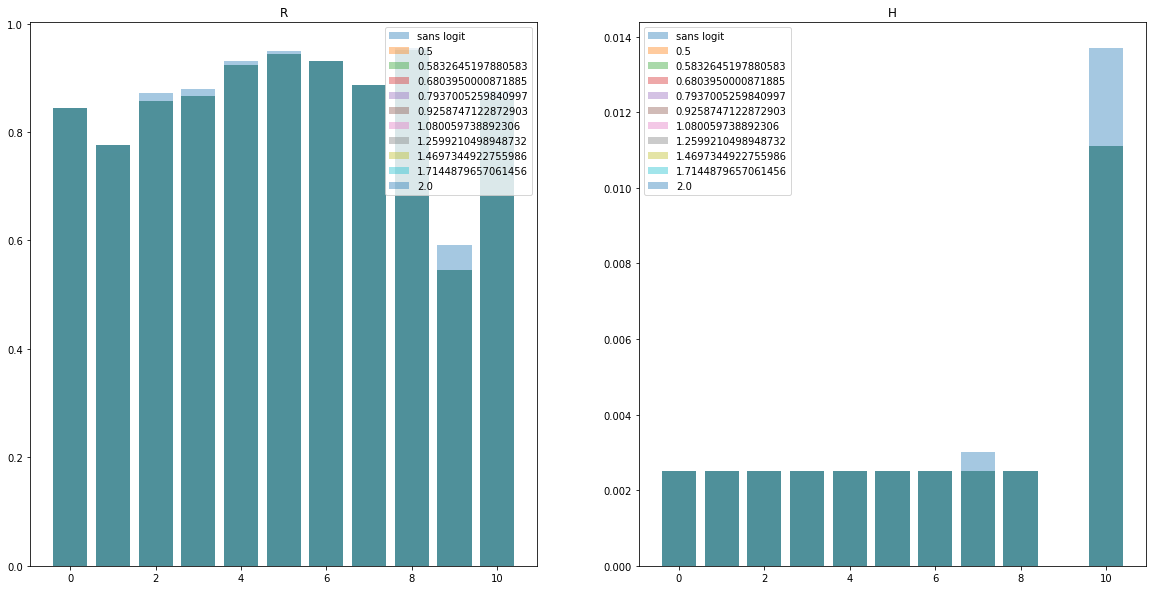

In [11]:
fig, ax = plt.subplots(1,2,figsize=(2*10,10))

ax[0].bar(np.arange(len(r_lala[0])), r_lala[0], alpha=0.4, label='sans logit')
ax[1].bar(np.arange(len(h_lala[0])), h_lala[0], alpha=0.4, label='sans logit')

for num, lala in enumerate(np.logspace(-1, 1, 10, base=2)) :
    ax[0].bar(np.arange(len(r_lala[num+1])), r_lala[num+1], alpha=0.4, label=lala)
    ax[1].bar(np.arange(len(h_lala[num+1])), h_lala[num+1], alpha=0.4, label=lala)
    
ax[0].legend() ; ax[1].legend()
ax[0].set_title('R') ; ax[1].set_title('H') ;